### Import required libraries

In [1]:
import numpy as np # for arrays
import pandas as pd # data processing
from PIL import Image # to control images
from glob import glob # used for paths names finding
import matplotlib.pyplot as plt
from tensorflow.keras.layers import add, Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model

import tensorflow as tf
tf.random.set_seed(2)
np.random.seed(1)

### Set global variables

In [ ]:
HOME=r"Image Enhancement task" # main folder
BLURRED_IMAGES_PATH=r'blurred_images' # blurred images folder
SHARPENED_IMAGES_PATH=r'sharped_images' # sharpened image folder
SAVED_DATASETS=r"Datasets" # for any new dataset will be made
SAVED_MODELS=r"Saved models" # For saved models

In [ ]:
# go to our working directory
%cd {HOME}

### Unzip images file

In [ ]:
if not glob(f"{BLURRED_IMAGES_PATH}"): # if this file already exists we won't need to unzip the file again
  !unzip  Image_Enhancement_Task_Dataset.zip

## Loading images

In [ ]:
# read all images relevant paths and append it to a list using regex to make it easier to open them

blurred_file=glob(f"{BLURRED_IMAGES_PATH}/*.jpg")
sharpened_file=glob(f"{SHARPENED_IMAGES_PATH}/*.jpg")

In [ ]:
# show the number of images we have

print(len(blurred_file),len(sharpened_file))
print(type(blurred_file),type(sharpened_file))

4060 4060
<class 'list'> <class 'list'>


In [ ]:
# sort the images names to make sure they are in the same order
blurred_file.sort()
sharpened_file.sort()

In [ ]:
def preprocess_images(images_file,target_size=(300, 150)):
    """
    function to read and resize images and append it to numpy array
    Parameters:
    images_file: list contains paths to our data
    target_size: tuple of the width and height we want to reshape our images to
    Returns:
    image_list: numpy array  of shape (number of images, width , height, channels) contains all of  our images
    """
    image_list = []

    for img_name in images_file:
        try:
            img = Image.open(img_name) #  read the image from path and return Image object
            img = img.resize(target_size) # resize the image to exact shape
            img_array = np.array(img, dtype=np.float32) / 255.0  # Normalization
            image_list.append(img_array) # append to list

        except Exception as e:
            print(f"Error processing {img_name}: {str(e)}")



    return np.array(image_list)

input_shape = (300, 150)





In [ ]:
if not glob('X_.npy'):
  # to save memory I will use first 1500 images for training and last 100 for testing
  X_=preprocess_images(blurred_file[:1500],target_size=input_shape)
  y_=preprocess_images(sharpened_file[:1500],target_size=input_shape)
  X_test=preprocess_images(blurred_file[-100:])
  y_test=preprocess_images(sharpened_file[-100:])

  #save numpy arrays to save computional power
  np.save(f"{SAVED_DATASETS}/X_.npy",X_)
  np.save(f"{SAVED_DATASETS}/y_.npy",y_)
  np.save(f"{SAVED_DATASETS}/X_test.npy",X_test)
  np.save(f"{SAVED_DATASETS}/y_test.npy",y_test)

In [ ]:
X_ = np.load(f"{SAVED_DATASETS}/X_.npy")
y_ = np.load(f"{SAVED_DATASETS}/y_.npy")
X_test = np.load(f"{SAVED_DATASETS}/X_test.npy")
y_test = np.load(f"{SAVED_DATASETS}/y_test.npy")

In [ ]:
print(X_.shape,y_.shape)
print(X_test.shape,y_test.shape)

(1500, 150, 300, 3) (1500, 150, 300, 3)
(100, 150, 300, 3) (100, 150, 300, 3)


In [ ]:
# Split the data into training and validation sets (you may also want to include a test set)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1200, 150, 300, 3),
 (1200, 150, 300, 3),
 (300, 150, 300, 3),
 (300, 150, 300, 3))

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model

# Define the U-Net model for image sharpening
def build_model(input_shape):
    # Encoder
    inputs = Input(shape=(input_shape))
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    # Decoder
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    outputs = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)  # Adjust channels as needed

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Example input shape with variable dimensions (height, width, channels)
input_shape = (None, None, 3)

# Build the model
model = build_model(input_shape)

# Compile the model with an appropriate loss function (e.g., mean squared error)
model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 64)    1792      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_transpose (Conv2DTra  (None, None, None, 64)   36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, None, None, 3)    1731      
 ranspose)                                                       
                                                                 
Total params: 77,379
Trainable params: 77,379
Non-trainable p

In [ ]:
from keras import callbacks
# Define training parameters
batch_size = 32
epochs = 40

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3)


# Train the model
history = model.fit(
    X_train,  # Blurred images
    y_train,  # Corresponding sharpened images
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[early_stopping],
)
# Evaluate the model on the validation set
val_loss = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss:.4f}")



Epoch 1/40
38/38 [==============================] - 27s 289ms/step - loss: 0.0295 - val_loss: 0.0221
Epoch 2/40
38/38 [==============================] - 8s 207ms/step - loss: 0.0162 - val_loss: 0.0127
Epoch 3/40
38/38 [==============================] - 8s 209ms/step - loss: 0.0109 - val_loss: 0.0107
Epoch 4/40
38/38 [==============================] - 8s 210ms/step - loss: 0.0099 - val_loss: 0.0101
Epoch 5/40
38/38 [==============================] - 8s 213ms/step - loss: 0.0094 - val_loss: 0.0093
Epoch 6/40
38/38 [==============================] - 8s 213ms/step - loss: 0.0085 - val_loss: 0.0081
Epoch 7/40
38/38 [==============================] - 8s 215ms/step - loss: 0.0074 - val_loss: 0.0072
Epoch 8/40
38/38 [==============================] - 8s 218ms/step - loss: 0.0067 - val_loss: 0.0068
Epoch 9/40
38/38 [==============================] - 8s 216ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 10/40
38/38 [==============================] - 8s 219ms/step - loss: 0.0060 - val_loss: 0.006

In [ ]:
model.save(f"{SAVED_MODELS}/image_sharpening_model_1.h5") # save the model

In [ ]:
model.load_weights(f'{SAVED_MODELS}/image_sharpening_model_1.h5') # load saved model

In [ ]:
predicted_images=model.predict(X_test) # test model on test dataset

4/4 [==============================] - 13s 3s/step


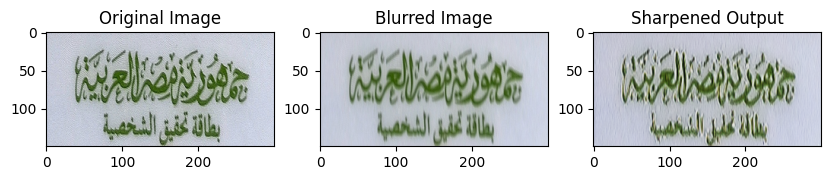

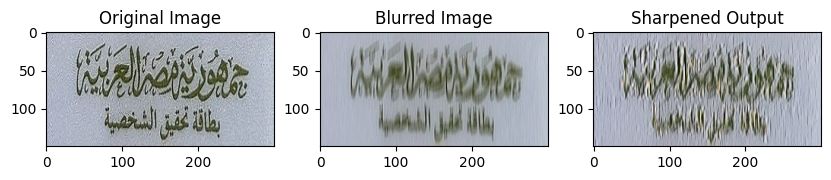

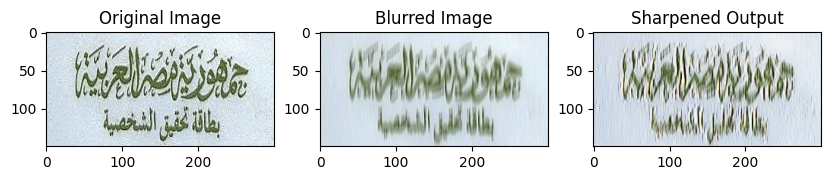

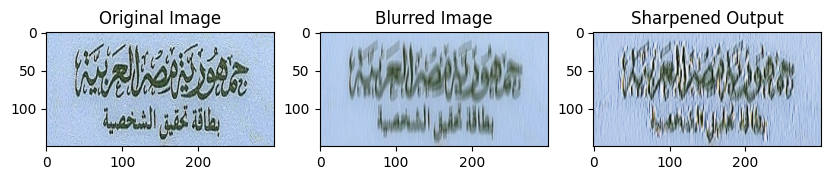

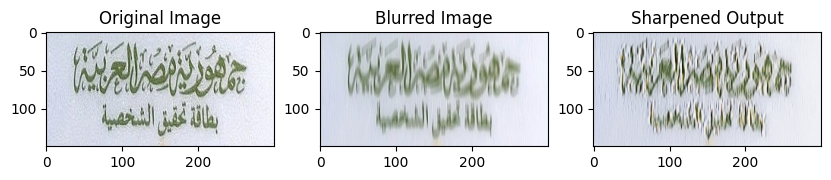

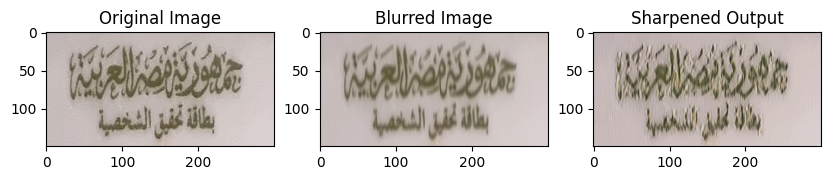

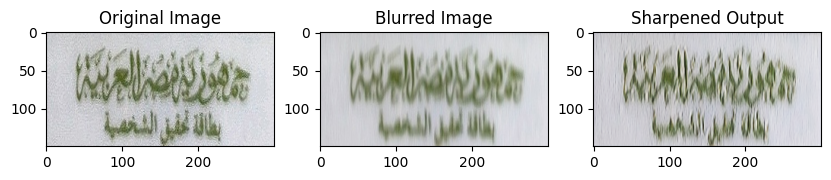

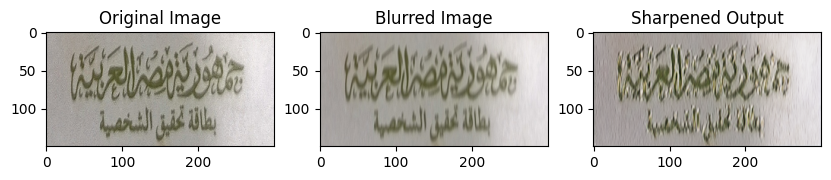

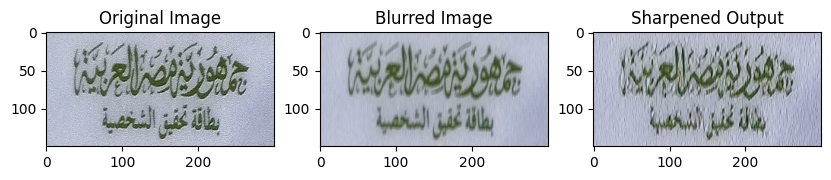

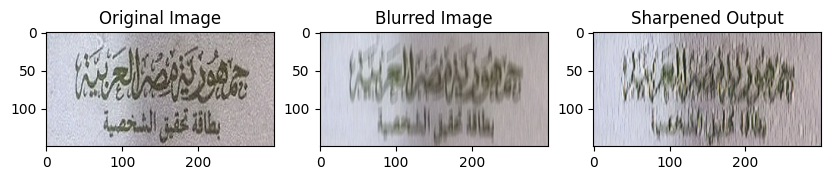

In [ ]:
import matplotlib.pyplot as plt

num_images = 10

for i in range(num_images):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(y_test[i])
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(X_test[i])
    plt.title("Blurred Image")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_images[i])
    plt.title("Sharpened Output")

    plt.show()

Actually the sharpened images is **not good** and needs a lot of working to be better and try using other models but because of the limited time and computational resources I will stop the work here But I believe GANs would be a game changer if I tried it.

### Conclusion

The U-Net model maybe not the best model for image enhancement and sharpening. But It was a good start and the following steps would be to find better architecture or build deeper model
In conclusion the field of image enhancement is big field and I can't discover all of it in this few days as the task is new for me but I enjoyed alot doing it